In [2]:
# Import modules
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')
pd.options.display.max_columns = 300
sns.set_style('darkgrid')

In [3]:
# Connect to PostgreSQL
conn = psycopg2.connect(database='usaspending', user='team', password='ZAQ!@#zaq123', host='dopelytics.site', port='5432')

### Initialize data set

In [4]:
# Select data elements 
sql_cols = ('federal_action_obligation, '
            #'total_dollars_obligated, '
            'base_and_exercised_options_value, '
            'base_and_all_options_value, '
            #'awarding_sub_agency_name, '
            'awarding_sub_agency_code, '
            #'awarding_office_name, '
            'awarding_office_code, '
            #'funding_sub_agency_name, '
            'funding_sub_agency_code, '
            #'funding_office_name, '  too many NaN
            'primary_place_of_performance_state_code, '
            'award_or_idv_flag, '
            #'award_type, '
            'award_type_code, '
            #'type_of_contract_pricing, '
            'type_of_contract_pricing_code, '
            #'dod_claimant_program_description, '
            'dod_claimant_program_code, '
            'type_of_set_aside_code, '
            #'multi_year_contract, ' too many NaN
            #'dod_acquisition_program_description, ' too many NaN
            #'subcontracting_plan, ' too many NaN
            #'contract_bundling, '
            'contract_bundling_code, '
            #'evaluated_preference, ' too many NaN
            #'national_interest_action, '
            'national_interest_action_code, '
            #'cost_or_pricing_data, ' too many NaN
            #'gfe_gfp, '
            'gfe_gfp_code, '
            #'contract_financing, '
            'contract_financing_code, '
            'portfolio_group, '
            #'product_or_service_code_description, '
            'product_or_service_code, '
            #'naics_bucket_title, ' too many NaN
            #'naics_description'
            'naics_code'
            )

# Create dataframe
sql_tbl_name = 'consolidated_data2'
df = pd.read_sql_query('SELECT ' + sql_cols + ' FROM ' + sql_tbl_name, con=conn)
print('Shape of initial df:', df.shape)

# Drop rows with NaN values
df = df.dropna()
print('Shape with no NaN values:', df.shape)

Shape of initial df: (272790, 19)
Shape with no NaN values: (270917, 19)


In [5]:
# Create two columns for set-aside (0/1) and contract value

def set_aside(c):
    if c['type_of_set_aside_code'] == 'NONE':
        return 0
    else:
        return 1

def contract_value(c):
    if c['base_and_exercised_options_value'] > 0:
        return c['base_and_exercised_options_value']
    elif c['base_and_all_options_value'] > 0:
        return c['base_and_all_options_value']
    elif c['federal_action_obligation'] > 0:
        return c['federal_action_obligation'] 
    else:
        return 0

df['set_aside'] = df.apply(set_aside, axis=1)
df['contract_value'] = df.apply(contract_value, axis=1)

# Drop columns that are no longer needed
df = df.drop(['type_of_set_aside_code','base_and_exercised_options_value','base_and_all_options_value',
              'federal_action_obligation'], axis=1)

## Feature Selection
#### Initialize Model

In [6]:
# Create feature and target dataframes
X_int = df.drop(['set_aside'], axis = 1)
y = df['set_aside']

# One hot encoding for features
X_int = pd.get_dummies(X_int)
print('Shape of OHE feature df:', X_int.shape)

Shape of OHE feature df: (270917, 2469)


In [7]:
# Import Random Forest Classifier modules
from sklearn.model_selection import train_test_split, cross_val_score
from yellowbrick.classifier import ClassificationReport
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, classification_report

In [8]:
# Fit initial model
X_train, X_test, y_train, y_test = train_test_split(X_int, y, test_size=0.20, random_state=42)
model = RandomForestClassifier(n_estimators=17, n_jobs=-1, random_state=0)
model.fit(X_train, y_train)
print('Model Accuracy: {:.2%}'.format(model.score(X_test, y_test)))

Model Accuracy: 91.14%


#### Find Important Features

In [9]:
# Calcultae feature importance
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
# Sort descending important features...
# Calculate cumalative percentage of total importance...
# Only keep features accounting for top 80% of feature importance
feature_importances['cumpercent'] = feature_importances['importance'].cumsum()/feature_importances['importance'].sum()*100
relevant_features = feature_importances[feature_importances.cumpercent < 80]
print('Shape of relevant features:', relevant_features.shape)

# Create list of relevant features to create new dataframe with only relevant features
list_relevant_features = list(relevant_features.index)

X = X_int[list_relevant_features]
print('Shape of initialized feature dataframe X with only relevant features:', X.shape)

Shape of relevant features: (221, 2)
Shape of initialized feature dataframe X with only relevant features: (270917, 221)


In [10]:
# Test accuracy of initialized dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = RandomForestClassifier(n_estimators=17, n_jobs=-1, random_state=0)
model.fit(X_train, y_train)
print('Model Accuracy: {:.2%}'.format(model.score(X_test, y_test)))

Model Accuracy: 90.38%


In [11]:
predictions = model.predict(X_test)

## Perform Random Forest Classification
#### Using only relevant features dataframe

In [12]:
classes = ['None', 'Set Aside']

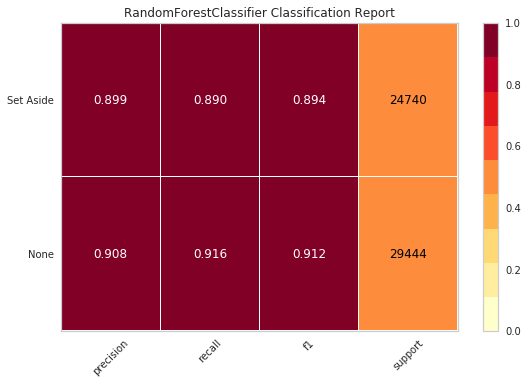

In [14]:
visualizer = ClassificationReport(model, classes=classes, support=True)
visualizer.score(X_test, y_test)
visualizer.show()

In [15]:
model_score_f1 = cross_val_score(estimator=model, X=X, y=y, scoring='f1', cv=12)
model_score_precision = cross_val_score(estimator=model, X=X, y=y, scoring='precision', cv=12)
model_score_recall = cross_val_score(estimator=model, X=X, y=y, scoring='recall', cv=12)

In [16]:
print("Accuracy : ", round(model_score_f1.mean(),3))
print('Standard Deviation : ',round(model_score_f1.std(),3))
print('Precision : ', round(model_score_precision.mean(),3))
print('Recall : ', round(model_score_recall.mean(),3))
print('Confusion Matrix')
print(confusion_matrix(y_test, predictions))

Accuracy :  0.899
Standard Deviation :  0.053
Precision :  0.904
Recall :  0.894
Confusion Matrix
[[26959  2485]
 [ 2725 22015]]


In [17]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91     29444
           1       0.90      0.89      0.89     24740

    accuracy                           0.90     54184
   macro avg       0.90      0.90      0.90     54184
weighted avg       0.90      0.90      0.90     54184



In [18]:
import pickle

In [19]:
#Save Trained Model
filename = 'RandomForest_SetAside_None_Model.save'
pickle.dump(model, open(filename, 'wb'))

## Perform Second Model - Predict Type of Set-Aside

In [20]:
df1 = pd.read_sql_query('SELECT ' + sql_cols + ' FROM ' + sql_tbl_name, con=conn)
print('Shape of initial df:', df1.shape)

Shape of initial df: (272790, 19)


In [21]:
# Drop all instances where type_of_set_aside_code = NONE
none_set_asides = df1[df1['type_of_set_aside_code'] == 'NONE'].index
df1 = df1.drop(none_set_asides, axis=0)
print('Shape of dataframe WITH set-asides:', df1.shape)

Shape of dataframe WITH set-asides: (124990, 19)


In [22]:
# Create column for contract value

def contract_value(c):
    if c['base_and_exercised_options_value'] > 0:
        return c['base_and_exercised_options_value']
    elif c['base_and_all_options_value'] > 0:
        return c['base_and_all_options_value']
    elif c['federal_action_obligation'] > 0:
        return c['federal_action_obligation'] 
    else:
        return 0
    
df1['contract_value'] = df1.apply(contract_value, axis=1)

# Assign numerics to set-aside codes
df1['set_aside_number'] = df1['type_of_set_aside_code'].map({'SBA':1, '8AN':2, '8A':3, 'SDVOSBC':4,'HZC':5, 'WOSB':6, 
                                                             'SBP':7, 'EDWOSB':7, 'SDVOSBS':7, 'HZS':7, 'WOSBSS':7, 
                                                             'EDWOSBSS':7, 'ISBEE':7, 'HS3':7, 'IEE':7})

# Drop columns that are no longer needed
df1 = df1.drop(['type_of_set_aside_code','base_and_exercised_options_value','base_and_all_options_value',
             'federal_action_obligation'], axis=1)

df1 = df1.dropna()
print('Shape of dataframe WITH set-asides with no NaN values:', df1.shape)

Shape of dataframe WITH set-asides with no NaN values: (123186, 17)


In [23]:
X1 = df1.drop(['set_aside_number'], axis=1).copy()
print('Shape of originial X1 dataframe:', X1.shape)

# One hot encoding
X1 = pd.get_dummies(X1)

# Create a list of relevant features in X1 based on the list of previous relevant features from feature selection
# Note numpy is taking only relevant features from the first feature selection that are also in X1
cols = list(X1.columns)
updated_list_relevant_features = np.asarray(list_relevant_features)[np.in1d(list_relevant_features, cols)].tolist()

# Updated dummy table with only relevant features
X1 = X1[updated_list_relevant_features]
print('Shape of X1 dummy dataframe:', X1.shape)

Shape of originial X1 dataframe: (123186, 16)
Shape of X1 dummy dataframe: (123186, 219)


In [24]:
y1 = df1['set_aside_number'].copy()

In [25]:
df1.head()

,awarding_sub_agency_code,awarding_office_code,funding_sub_agency_code,primary_place_of_performance_state_code,award_or_idv_flag,award_type_code,type_of_contract_pricing_code,dod_claimant_program_code,contract_bundling_code,national_interest_action_code,gfe_gfp_code,contract_financing_code,portfolio_group,product_or_service_code,naics_code,contract_value,set_aside_number
1,1700,N62439,1700,MI,AWARD,C,J,S1,D,NONE,N,Z,Transportation Services,V231,721110.0,11790.00,1.0
3,2100,W911N2,2100,PA,AWARD,C,J,C2,D,NONE,N,Z,Facility Related Services,Z1EB,236210.0,151025.07,3.0
4,5700,FA4897,5700,ID,AWARD,C,J,S1,D,NONE,N,Z,Knowledge Based Services,R497,622110.0,1339647.84,1.0
7,1700,N62271,1700,CA,AWARD,B,J,S1,D,NONE,Y,Z,Research and Development,AC11,336411.0,28465.51,1.0
19,5700,FA4819,5700,FL,AWARD,C,K,C2,D,NONE,N,Z,Construction Services,Y1JZ,236220.0,67192.99,3.0


In [26]:
y1.value_counts()

1.0    76884
2.0    19629
3.0    15205
4.0     4153
5.0     3833
6.0     1998
7.0     1484
Name: set_aside_number, dtype: int64

In [27]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20, random_state=42)

In [28]:
model1 = RandomForestClassifier(n_estimators=17)

In [29]:
model1.fit(X1_train, y1_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=17,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [30]:
X1_train.shape

(98548, 219)

In [31]:
classes1 = ['SBA', '8AN', '8A', 'SDVOSBC','HZC', 'WOSB', 'OTHER SET ASIDE']

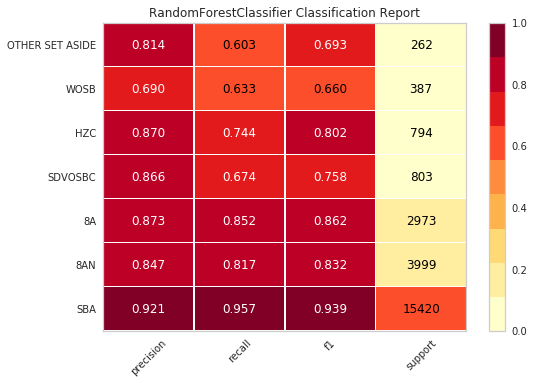

In [32]:
visualizer = ClassificationReport(model1, classes=classes1, support=True)
visualizer.score(X1_test, y1_test)
visualizer.show()

In [33]:
predictions_all_set_aside = model1.predict(X1_test)

In [34]:
print(classification_report(y1_test, predictions_all_set_aside))

              precision    recall  f1-score   support

         1.0       0.92      0.96      0.94     15420
         2.0       0.85      0.82      0.83      3999
         3.0       0.87      0.85      0.86      2973
         4.0       0.87      0.67      0.76       803
         5.0       0.87      0.74      0.80       794
         6.0       0.69      0.63      0.66       387
         7.0       0.81      0.60      0.69       262

    accuracy                           0.90     24638
   macro avg       0.84      0.75      0.79     24638
weighted avg       0.89      0.90      0.89     24638



In [35]:
X2 = pd.DataFrame(data=X1, columns=X1.columns)
X2.head()

,contract_value,naics_code,portfolio_group_Electronic & Communication Services,dod_claimant_program_code_C2,dod_claimant_program_code_S1,portfolio_group_Facility Related Services,primary_place_of_performance_state_code_VA,award_type_code_C,awarding_sub_agency_code_97AK,type_of_contract_pricing_code_J,product_or_service_code_D304,primary_place_of_performance_state_code_CA,award_type_code_B,awarding_sub_agency_code_2100,award_type_code_A,primary_place_of_performance_state_code_WA,primary_place_of_performance_state_code_MD,award_type_code_D,funding_sub_agency_code_1700,awarding_office_code_SP4500,portfolio_group_Transportation Services,portfolio_group_Knowledge Based Services,type_of_contract_pricing_code_U,funding_sub_agency_code_96CE,primary_place_of_performance_state_code_FL,awarding_sub_agency_code_5700,gfe_gfp_code_Y,primary_place_of_performance_state_code_IN,contract_financing_code_Z,primary_place_of_performance_state_code_TX,awarding_office_code_HC1013,portfolio_group_Equipment Related Services,dod_claimant_program_code_C9E,product_or_service_code_Z2JZ,primary_place_of_performance_state_code_GA,funding_sub_agency_code_5700,portfolio_group_Medical Services,portfolio_group_Construction Services,funding_sub_agency_code_2100,portfolio_group_Research and Development,primary_place_of_performance_state_code_PA,primary_place_of_performance_state_code_AK,primary_place_of_performance_state_code_AL,product_or_service_code_R499,primary_place_of_performance_state_code_NC,product_or_service_code_S216,gfe_gfp_code_N,contract_financing_code_A,contract_financing_code_C,awarding_office_code_N40085,product_or_service_code_R425,product_or_service_code_C211,product_or_service_code_S208,funding_sub_agency_code_97AS,awarding_office_code_HTC711,product_or_service_code_Q201,product_or_service_code_S222,awarding_office_code_N55236,awarding_sub_agency_code_1700,primary_place_of_performance_state_code_SC,primary_place_of_performance_state_code_HI,primary_place_of_performance_state_code_UT,awarding_office_code_W9124P,awarding_sub_agency_code_97AS,primary_place_of_performance_state_code_IL,product_or_service_code_J066,awarding_office_code_N00189,product_or_service_code_U005,primary_place_of_performance_state_code_NY,product_or_service_code_C219,primary_place_of_performance_state_code_DC,primary_place_of_performance_state_code_OH,product_or_service_code_S201,primary_place_of_performance_state_code_NJ,primary_place_of_performance_state_code_AZ,primary_place_of_performance_state_code_KS,primary_place_of_performance_state_code_LA,awarding_office_code_N00173,product_or_service_code_J999,awarding_office_code_W25G1V,product_or_service_code_J065,awarding_office_code_N62645,primary_place_of_performance_state_code_MA,product_or_service_code_C1QA,primary_place_of_performance_state_code_MO,product_or_service_code_R699,product_or_service_code_U099,product_or_service_code_Z2AA,primary_place_of_performance_state_code_TN,primary_place_of_performance_state_code_CO,primary_place_of_performance_state_code_OK,primary_place_of_performance_state_code_GU,product_or_service_code_F999,primary_place_of_performance_state_code_MS,dod_claimant_program_code_A7,awarding_office_code_N40080,product_or_service_code_R408,funding_sub_agency_code_97AK,product_or_service_code_D399,product_or_service_code_W085,product_or_service_code_R426,product_or_service_code_D319,product_or_service_code_J099,contract_financing_code_D,awarding_office_code_N62473,product_or_service_code_V231,dod_claimant_program_code_A3,type_of_contract_pricing_code_S,primary_place_of_performance_state_code_CT,dod_claimant_program_code_A1C,primary_place_of_performance_state_code_KY,primary_place_of_performance_state_code_MI,product_or_service_code_S205,product_or_service_code_Z2AZ,awarding_office_code_N69450,product_or_service_code_Z1JZ,awarding_office_code_N68335,product_or_service_code_J059,product_or_service_code_V119,awarding_office_code_W91278,awarding_office_code_N39430,product_or_service_code_S203,product_or_servic

In [36]:
X2['set_aside_number'] = y1

In [37]:
X2.head()

,contract_value,naics_code,portfolio_group_Electronic & Communication Services,dod_claimant_program_code_C2,dod_claimant_program_code_S1,portfolio_group_Facility Related Services,primary_place_of_performance_state_code_VA,award_type_code_C,awarding_sub_agency_code_97AK,type_of_contract_pricing_code_J,product_or_service_code_D304,primary_place_of_performance_state_code_CA,award_type_code_B,awarding_sub_agency_code_2100,award_type_code_A,primary_place_of_performance_state_code_WA,primary_place_of_performance_state_code_MD,award_type_code_D,funding_sub_agency_code_1700,awarding_office_code_SP4500,portfolio_group_Transportation Services,portfolio_group_Knowledge Based Services,type_of_contract_pricing_code_U,funding_sub_agency_code_96CE,primary_place_of_performance_state_code_FL,awarding_sub_agency_code_5700,gfe_gfp_code_Y,primary_place_of_performance_state_code_IN,contract_financing_code_Z,primary_place_of_performance_state_code_TX,awarding_office_code_HC1013,portfolio_group_Equipment Related Services,dod_claimant_program_code_C9E,product_or_service_code_Z2JZ,primary_place_of_performance_state_code_GA,funding_sub_agency_code_5700,portfolio_group_Medical Services,portfolio_group_Construction Services,funding_sub_agency_code_2100,portfolio_group_Research and Development,primary_place_of_performance_state_code_PA,primary_place_of_performance_state_code_AK,primary_place_of_performance_state_code_AL,product_or_service_code_R499,primary_place_of_performance_state_code_NC,product_or_service_code_S216,gfe_gfp_code_N,contract_financing_code_A,contract_financing_code_C,awarding_office_code_N40085,product_or_service_code_R425,product_or_service_code_C211,product_or_service_code_S208,funding_sub_agency_code_97AS,awarding_office_code_HTC711,product_or_service_code_Q201,product_or_service_code_S222,awarding_office_code_N55236,awarding_sub_agency_code_1700,primary_place_of_performance_state_code_SC,primary_place_of_performance_state_code_HI,primary_place_of_performance_state_code_UT,awarding_office_code_W9124P,awarding_sub_agency_code_97AS,primary_place_of_performance_state_code_IL,product_or_service_code_J066,awarding_office_code_N00189,product_or_service_code_U005,primary_place_of_performance_state_code_NY,product_or_service_code_C219,primary_place_of_performance_state_code_DC,primary_place_of_performance_state_code_OH,product_or_service_code_S201,primary_place_of_performance_state_code_NJ,primary_place_of_performance_state_code_AZ,primary_place_of_performance_state_code_KS,primary_place_of_performance_state_code_LA,awarding_office_code_N00173,product_or_service_code_J999,awarding_office_code_W25G1V,product_or_service_code_J065,awarding_office_code_N62645,primary_place_of_performance_state_code_MA,product_or_service_code_C1QA,primary_place_of_performance_state_code_MO,product_or_service_code_R699,product_or_service_code_U099,product_or_service_code_Z2AA,primary_place_of_performance_state_code_TN,primary_place_of_performance_state_code_CO,primary_place_of_performance_state_code_OK,primary_place_of_performance_state_code_GU,product_or_service_code_F999,primary_place_of_performance_state_code_MS,dod_claimant_program_code_A7,awarding_office_code_N40080,product_or_service_code_R408,funding_sub_agency_code_97AK,product_or_service_code_D399,product_or_service_code_W085,product_or_service_code_R426,product_or_service_code_D319,product_or_service_code_J099,contract_financing_code_D,awarding_office_code_N62473,product_or_service_code_V231,dod_claimant_program_code_A3,type_of_contract_pricing_code_S,primary_place_of_performance_state_code_CT,dod_claimant_program_code_A1C,primary_place_of_performance_state_code_KY,primary_place_of_performance_state_code_MI,product_or_service_code_S205,product_or_service_code_Z2AZ,awarding_office_code_N69450,product_or_service_code_Z1JZ,awarding_office_code_N68335,product_or_service_code_J059,product_or_service_code_V119,awarding_office_code_W91278,awarding_office_code_N39430,product_or_service_code_S203,product_or_servic

In [38]:
# Next I am testing the accuracy of the model on each specific set aside. Because we have an unbalanced data set
# it seems that the model is great for predicting set asides in general, however it is also skewed to better
# predict certain categories compared to others.

# Create a dictionary object to capture set aside code and it's score
class scores(dict):  
  
    # __init__ function  
    def __init__(self):  
        self = dict()  
          
    # Function to add key:value  
    def add(self, key, value):  
        self[key] = value  

scores = scores()
percent = ''
set_aside_codes = X2['set_aside_number'].unique()
print(set_aside_codes)


# Loop through each set aside, test it, and append to the dictionary
for set_aside in set_aside_codes:
    dataPoint = X2.loc[X2['set_aside_number'] == set_aside]
    XPoint = dataPoint.drop(['set_aside_number'],axis=1)
    yPoint = dataPoint['set_aside_number']
    percent = model1.score(XPoint, yPoint)
    percent = round(percent, 4)
    scores.add(set_aside, percent)

[1. 3. 2. 7. 6. 5. 4.]


In [39]:
# Sort the dictionary by score
import operator
sortedScores = sorted(scores.items(), key=operator.itemgetter(1))

In [40]:
# Print scores
for score in reversed(sortedScores):      
    print("{:<8} {:.2%}".format(score[0], score[1]))

1.0      99.02%
3.0      96.34%
2.0      95.80%
5.0      93.74%
4.0      92.66%
7.0      90.23%
6.0      90.09%


In [41]:
model_score_all_set_aside_f1 = cross_val_score(estimator=model1, X=X1, y=y1, scoring='f1_weighted', cv=12)
model_score_all_set_aside_precision = cross_val_score(estimator=model1, X=X1, y=y1, scoring='precision_weighted', cv=12)
model_score_all_set_aside_recall = cross_val_score(estimator=model1, X=X1, y=y1, scoring='recall_weighted', cv=12)

In [42]:
print("Accuracy : ", round(model_score_all_set_aside_f1.mean(),2))
print('Standard Deviation : ',round(model_score_all_set_aside_f1.std(),3))
print('Precision : ', round(model_score_all_set_aside_precision.mean(),3))
print('Recall : ', round(model_score_all_set_aside_recall.mean(),3))
print("")
print('Confusion Matrix')
print(confusion_matrix(y1_test, predictions_all_set_aside))

Accuracy :  0.99
Standard Deviation :  0.005
Precision :  0.992
Recall :  0.992

Confusion Matrix
[[14760   289   176    40    36    95    24]
 [  562  3267   121    21    16     4     8]
 [  250   154  2532     9    23     4     1]
 [  160    63    23   541    11     4     1]
 [   98    49    42    12   591     2     0]
 [  125    12     2     1     0   245     2]
 [   74    22     4     1     2     1   158]]


In [43]:
#Save Trained Model
filename = 'RandomForest_All_Set_Aside_Model.save'
pickle.dump(model, open(filename, 'wb'))